# Surrogate Model
### Training of Feedforward Neural Network with special architecture for Ordinal Classification

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pickle
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.sm_dataloader import *
from src.preprocessing.sm_label_transformer import *
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

### 1. Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

### 2. Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetSM(train=True, path="data/surrogate_model")
test_dataset = DatasetSM(train=False, path="data/surrogate_model")
train_dataset.X.shape

torch.Size([9650, 38])

In [5]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 0.],
        ...,
        [1., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

### 3. Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 12:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

with open('models/sm_train_standard_scaler_skew_-1_70.pkl', 'wb') as output:
    pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)

In [7]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.8262,  0.9302,  0.0199],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8262,  1.2502,  0.0199],
        [ 1.0000,  0.0000,  0.0000,  ..., -1.8865, -2.0006,  0.0199],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.4181,  0.0049,  0.0199],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.4089, -0.0364,  0.0199],
        [ 0.0000,  1.0000,  0.0000,  ...,  1.4181,  0.0049,  0.0199]])

### 4. Train model

#### 4.1 Build model and switch to GPU if available

In [10]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [11]:
res = fitness_function(test_dataset.X[:5])
print(res)
torch.sigmoid(res)

tensor([[ 0.6286,  0.3786,  0.1286, -0.1214],
        [ 0.6286,  0.3786,  0.1286, -0.1214],
        [ 0.5995,  0.3495,  0.0995, -0.1505],
        [ 0.6286,  0.3786,  0.1286, -0.1214],
        [ 0.7219,  0.4719,  0.2219, -0.0281]], grad_fn=<AddBackward0>)


tensor([[0.6522, 0.5935, 0.5321, 0.4697],
        [0.6522, 0.5935, 0.5321, 0.4697],
        [0.6455, 0.5865, 0.5249, 0.4625],
        [0.6522, 0.5935, 0.5321, 0.4697],
        [0.6730, 0.6158, 0.5553, 0.4930]], grad_fn=<SigmoidBackward>)

#### 4.2 Define optimizer and additional measure to report (optional)

In [12]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### 4.3 Define Data loaders

In [13]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### 4.4 Actual Model training

In [14]:
n_epochs = 70

# Stuff to store
train_losses = np.zeros(n_epochs)
train_bin_maes = np.zeros(n_epochs)
train_accuracies = np.zeros(n_epochs)
train_label_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_bin_maes = np.zeros(n_epochs)
test_accuracies = np.zeros(n_epochs)
test_label_maes = np.zeros(n_epochs)


for it in range(n_epochs):
    train_loss = []
    test_loss = []
    train_bin_mae = []
    test_bin_mae = []
    train_label_mae = []
    test_label_mae = []
    correct_train = 0
    correct_test = 0
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss and other report measures
        train_loss.append(loss.item())
        train_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        train_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        
        # Count correct predictions
        correct_train += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
        
    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_bin_mae = np.mean(train_bin_mae)
    train_label_mae = np.mean(train_label_mae)
    
    # Get train accuracy
    train_accuracy = correct_train / len(train_dataset.X)
    
    predicted_classes = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        test_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        correct_test += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
    test_loss = np.mean(test_loss)
    test_bin_mae = np.mean(test_bin_mae)
    test_label_mae = np.mean(test_label_mae)
    test_accuracy = correct_test / len(test_dataset.X)

    # Save losses
    train_losses[it] = train_loss
    train_bin_maes[it] = train_bin_mae
    test_losses[it] = test_loss
    test_bin_maes[it] = test_bin_mae
    train_label_maes[it] = train_label_mae
    test_label_maes[it] = test_label_mae
    train_accuracies[it] = train_accuracy
    test_accuracies[it] = test_accuracy

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
              f' Train Binary MAE: {train_bin_mae:.4f}, Test Binary MAE: {test_bin_mae:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Label MAE:  {train_label_mae:.4f}, Test Label MAE:  {test_label_mae:.4f}')

Epoch 1/70, Train Loss: 2.4223, Test Loss: 2.2931 Train Binary MAE: 0.4420, Test Binary MAE: 0.4168, Train Accuracy: 0.2537, Test Accuracy: 0.2751, Train Label MAE:  1.2436, Test Label MAE:  1.1445
Epoch 10/70, Train Loss: 1.7805, Test Loss: 1.7768 Train Binary MAE: 0.3225, Test Binary MAE: 0.3237, Train Accuracy: 0.4678, Test Accuracy: 0.4740, Train Label MAE:  0.7105, Test Label MAE:  0.6667
Epoch 20/70, Train Loss: 1.6282, Test Loss: 1.6423 Train Binary MAE: 0.2852, Test Binary MAE: 0.2872, Train Accuracy: 0.4607, Test Accuracy: 0.4616, Train Label MAE:  0.6875, Test Label MAE:  0.6610
Epoch 30/70, Train Loss: 1.5580, Test Loss: 1.5834 Train Binary MAE: 0.2649, Test Binary MAE: 0.2667, Train Accuracy: 0.4585, Test Accuracy: 0.4708, Train Label MAE:  0.6779, Test Label MAE:  0.6489
Epoch 40/70, Train Loss: 1.5230, Test Loss: 1.5457 Train Binary MAE: 0.2531, Test Binary MAE: 0.2544, Train Accuracy: 0.4565, Test Accuracy: 0.4713, Train Label MAE:  0.6736, Test Label MAE:  0.6385
Epoch 

### 5. Evaluate model performance

#### 5.1 Compute benchmark performance values

In [27]:
unique_train, counts_train = np.unique(decode_classes(train_dataset.y).flatten(), return_counts=True)
train_scores = dict(zip(unique_train, counts_train))
n_train = len(train_dataset)

print(f'Number of training instances: {n_train}')
print(f'Distribution of reward classes in training dataset: {train_scores}')

Number of training instances: 9650
Distribution of reward classes in training dataset: {0: 2580, 1: 2143, 2: 3096, 3: 1521, 4: 310}


In [28]:
unique_test, counts_test = np.unique(decode_classes(test_dataset.y).flatten(), return_counts=True)
test_scores = dict(zip(unique_test, counts_test))
n_test = len(test_dataset)

print(f'Number of test instances: {n_test}')
print(f'Distribution of reward classes in test dataset: {test_scores}')

Number of test instances: 2177
Distribution of reward classes in test dataset: {0: 498, 1: 414, 2: 763, 3: 412, 4: 90}


In [36]:
# Accuracy for majority classifier
acc = test_scores[2]/n_test
print(f'Test Benchmark Accuracy: {acc :.4f}')

Test Benchmark Accuracy: 0.3505


In [35]:
# Label MAE for constant prediction of class 2
label_mae = 2*(test_scores[0]+test_scores[4])/n_test + 1*(test_scores[1]+test_scores[3])/n_test
print(f'Test Benchmark Label MAE: {label_mae :.4f}')

Test Benchmark Label MAE: 0.9196


In [34]:
# Binary MAE for constant prediction of class 2 (1,1,0,0)
binary_mae = (test_scores[0]*0.5 + test_scores[1]*0.25 + test_scores[3]*0.25 + test_scores[4]*0.5)/n_test
print(f'Test Benchmark Binary MAE: {binary_mae :.4f}')

Test Benchmark Binary MAE: 0.2299


#### 5.2 Plot the train loss and test loss per epoch

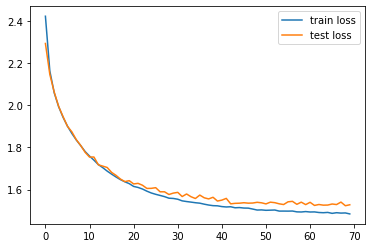

In [32]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

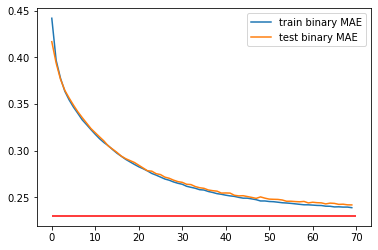

In [37]:
plt.plot(train_bin_maes, label='train binary MAE')
plt.plot(test_bin_maes, label='test binary MAE')
plt.hlines(binary_mae, xmin=0, xmax=n_epochs, color='red')
plt.legend()
plt.show()

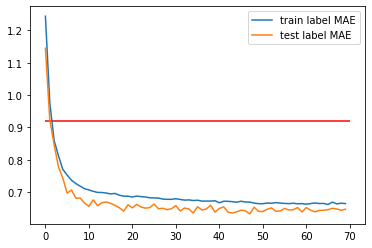

In [38]:
plt.plot(train_label_maes, label='train label MAE')
plt.plot(test_label_maes, label='test label MAE')
plt.hlines(label_mae, xmin=0, xmax=n_epochs, color='red')
plt.legend()
plt.show()

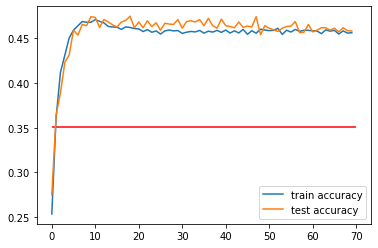

In [39]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.hlines(acc, xmin=0, xmax=n_epochs, color='red')
plt.legend()
plt.show()

### 6. Save trained model

In [15]:
torch.save(fitness_function.state_dict(), "models/sm_fnn_skew_-1_70.pth")